In [1]:
import time, datetime
import numpy as np
from numpy import zeros, sqrt, pi, vectorize
from numpy.linalg import pinv, inv
from multiprocessing import Process, Queue
#import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from error_analysis_class import *
from noshellavg import *
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
def snr_interpolation(kbin2, SNR_Xi):

    from sklearn.gaussian_process import GaussianProcess

    outlier_mask = np.ones(kbin2.size, dtype=bool)
    
    for i in range(1, kbin2.size):
        if (SNR_Xi[i] < SNR_Xi[i-1]): outlier_mask[i-1] = 0
        if (SNR_Xi[i] < SNR_Xi[i-1]): outlier_mask[i] = 0
        
     
    kbin_m = kbin2[outlier_mask]
    SNR_Xi_m = SNR_Xi[outlier_mask]
    
    #------------------------------------------------------------
    # Generate data
    #z_sample, mu_sample = kbin_m[kbin_m.size/30:], SNR_Xi_m[kbin_m.size/30:]
    z_sample, mu_sample = kbin_m, SNR_Xi_m
    
    #outlier_mask = (mu_sample > -100) & (mu_sample < 550000)
    

    dmu = mu_sample * 1e-6
    #dmu = mu_sample * 1./ mu_sample.max()
    #dmu[dmu.size/20:dmu.size/10] = dmu[dmu.size/20:dmu.size/10] /10
    #dmu[:dmu.size/30] = dmu[:dmu.size/30] * 5
    
    #z = np.linspace(0, 2, 1000)
    #mu_true = np.asarray(map(cosmo.mu, z))

    #------------------------------------------------------------
    # fit the data
    # Mesh the input space for evaluations of the real function,
    # the prediction and its MSE
    #z_fit = np.linspace(0, 2, 1000)
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                         thetaL=1e-2, thetaU=1,
                         normalize=False,
                         nugget= (dmu / mu_sample) ** 2,
                         random_start=1)
    gp.fit(z_sample[:, None], mu_sample)
    
    kbin3 = np.linspace(KMIN, KMAX, kN_y)
    y_pred, MSE = gp.predict(kbin3[:, None], eval_MSE=True)    
    #y_pred, MSE = gp.predict(kcenter[:,None], eval_MSE=True)
    sigma = np.sqrt(MSE)

    return kbin3, y_pred, sigma #,kbin2[:kbin2.size/20], y_fit

In [21]:
D1 = np.loadtxt('data_txt/snr_rmax200_rmin0.txt')
kbin, SNR_P, kbin2, SNR_Xi = [D1[:,i] for i in range(D1[0,:].size)]

from scipy import interpolate
SNR_Xi_ftn = interpolate.InterpolatedUnivariateSpline(kbin2,SNR_Xi)

In [28]:
from scipy.optimize import curve_fit

In [40]:
def func(x, a, b, c):
    return a*np.exp(-b*x)-c

In [35]:
polyfitted = np.polyfit(kbin2, SNR_Xi, 10)

In [37]:
kk = np.linspace(0,2,20)

In [38]:
y = np.zeros(len(kk))
for i in range(len(polyfitted)):
    y+= polyfitted[i]*kk**i

In [33]:
popt, pcov = curve_fit(func, kbin2, SNR_Xi, bounds=(0, [1, 0.001]))

TypeError: leastsq() got an unexpected keyword argument 'bounds'

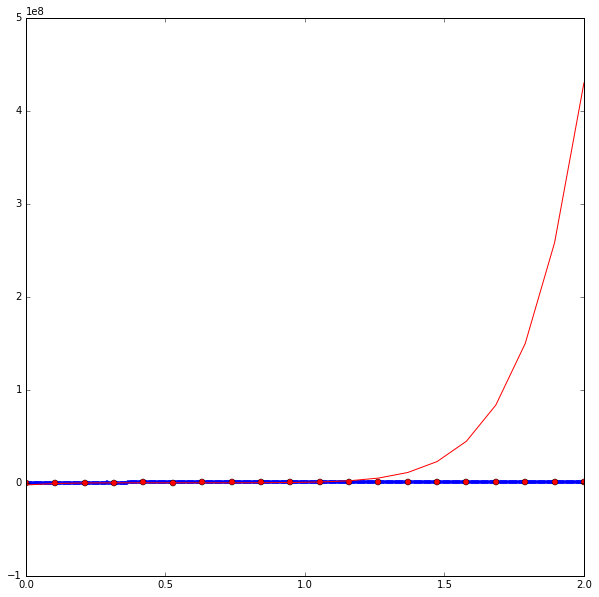

In [41]:
fig, ax = plt.subplots( figsize = (10,10))
ax.plot(kbin2, SNR_Xi, '.')
ax.plot(kk, SNR_Xi_ftn(kk), 'ro')
#ax.plot(kbin2, func(kbin2, *popt), 'r-', label='fit')
ax.plot(kk, y, 'r-', label='fit')